# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import csv
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tqdm import tqdm, tqdm_notebook, tnrange
import tensorflow as tf
import math
import os


Using TensorFlow backend.


In [2]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = "/home/shreyas/Documents/sdcND/data/lab2/train.p"
testing_file = "/home/shreyas/Documents/sdcND/data/lab2/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [3]:
# number of training examples
n_train = len(X_train)
# TODO: number of testing examples
n_test = len(X_test)
# TODO: what's the shape of an image?
image_shape = X_train[0].shape
# TODO: how many classes are in the dataset
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [4]:
### import and extract the signnames
signnames = []
with open('signnames.csv', newline='') as csvfile:
    signname_file = csv.reader(csvfile)
    next(signname_file, None)
    for row in signname_file:
        signnames.append(row[1])

In [5]:
def plot_img(images, labels, pred_labels=None):
    '''
    images - 5 given images to plotted
    labels - true labels of images
    pred_labels - predicted labels
    Creates a 1x5 plot for given images'''
   
    f, axes = plt.subplots(1,5,figsize=(12, 3))
    f.subplots_adjust(wspace=.3)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        #sinplot()
        
        if pred_labels is None:
            xlabel = "{}\n{}".format(labels[i], signnames[labels[i]])
        else:
            xlabel = "given {}: {}\npredicate {}: {}".format(labels[i], signnames[labels[i]], 
                                                             pred_labels[i], signnames[pred_labels[i]])
        
        ax.set_xlabel(xlabel)
        #remove ticks from the plot
        ax.set_xticks([])
        ax.set_yticks([])

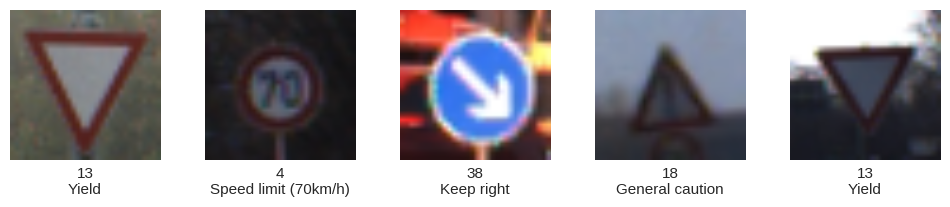

In [6]:
images = np.random.choice(len(X_train),5)
plot_img(X_train[images], y_train[images])

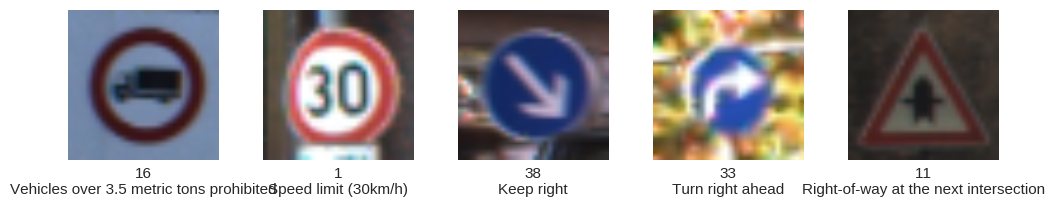

In [7]:
plot_img(X_test[:5],y_test[:5])

In [8]:
from collections import Counter
data_distribution = Counter(y_train)
label_list = set(y_train)
len(label_list)

43

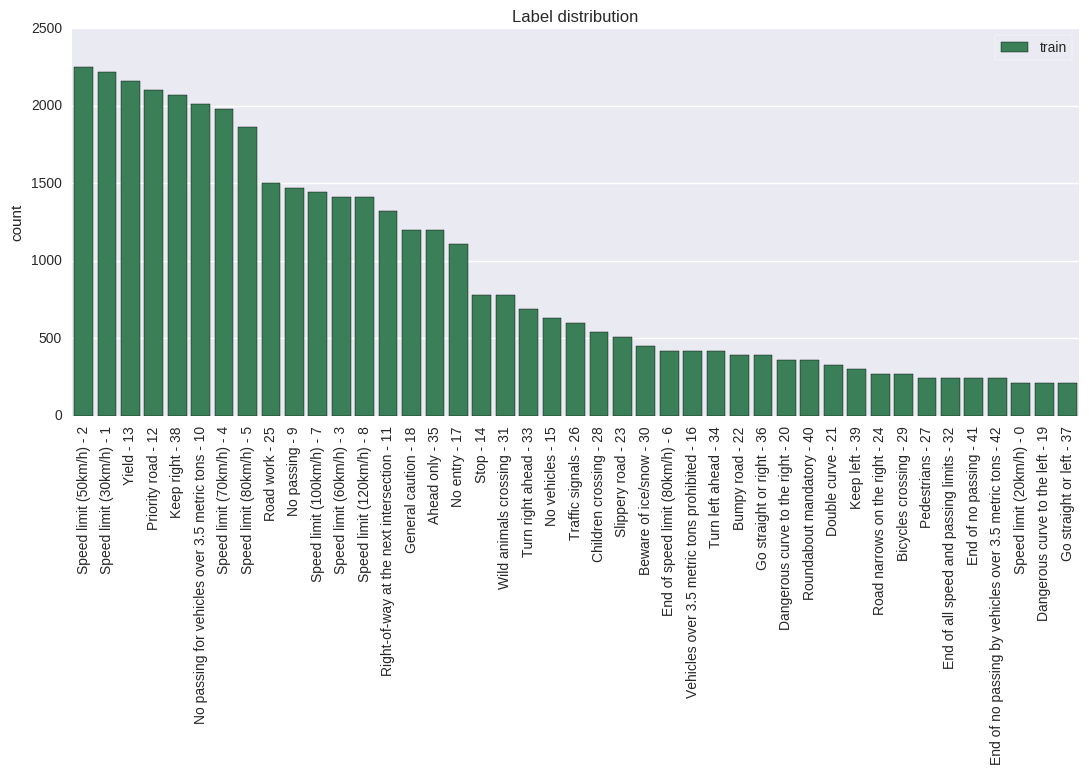

In [9]:
order = list(zip(*data_distribution.most_common()))[0]

f, ax = plt.subplots(figsize=(13, 5))
ax = sns.countplot(x=y_train, order=order, color='seagreen', ax=ax, label="train")

#ax = sns.countplot(x=y_test, order=order, color='lightblue', ax=ax, label="test")

_ = ax.set_title('Label distribution')
_ = ax.legend(ncol=2, loc="upper right", frameon=True)
_ = ax.set_xticklabels(['%s - %s'% (signnames[i], i) for i in order], rotation=90)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [10]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [11]:
def augument_data(x, y,
                  rotation = 29, 
                  trans_range = 0.3, 
                  channel_shift = 0.01):
    
    datagen = ImageDataGenerator(rotation_range=rotation,                           
                                 channel_shift_range=channel_shift,
                                 shear_range=trans_range,
                                 zoom_range=trans_range,
                                 width_shift_range=trans_range,
                                 height_shift_range=trans_range,
                                 fill_mode='nearest')

    datagen.fit(x, seed=42)
    batch_size = min(x.shape[0],(1781-x.shape[0]))
    nb_transforms = int(math.ceil(1700/x.shape[0]))-1
    #print ("batchsize: {}, nb_transforms: {}".format(batch_size, nb_transforms))
    for i in range(nb_transforms):       
        X_batch, y_batch = next(datagen.flow(x, y, batch_size=batch_size, seed=42))

        x = np.concatenate((x, X_batch), axis=0)
        y = np.concatenate((y, y_batch), axis=0)
        
    return x,y

In [12]:
X_a = np.zeros(shape=(0,32,32,3))
y_a = np.zeros(shape=(0,))

for label in label_list:
        index_list = [i for i, x in enumerate(y_train) if x == label]
        x_b, y_b = augument_data(X_train[index_list], y_train[index_list])
        X_a = np.concatenate((X_a, x_b), axis=0)
        y_a = np.concatenate((y_a, y_b), axis=0)
        #print (label, len(y_a))

In [13]:
aug_data_distribution = Counter(y_a)

Counter({1: 3562, 2: 3552, 13: 3476, 12: 3451, 38: 3444, 4: 3372, 10: 3369, 5: 3271, 25: 2995, 9: 2945, 7: 2927, 3: 2919, 8: 2898, 11: 2842, 18: 2749, 35: 2748, 17: 2678, 33: 2645, 28: 2544, 15: 2520, 26: 2515, 14: 2512, 31: 2472, 16: 2303, 22: 2275, 39: 2178, 23: 2170, 36: 2156, 21: 2112, 20: 2079, 30: 2076, 34: 2076, 6: 2052, 37: 2016, 40: 1995, 0: 1992, 27: 1990, 32: 1960, 29: 1953, 24: 1935, 41: 1930, 42: 1910, 19: 1892})


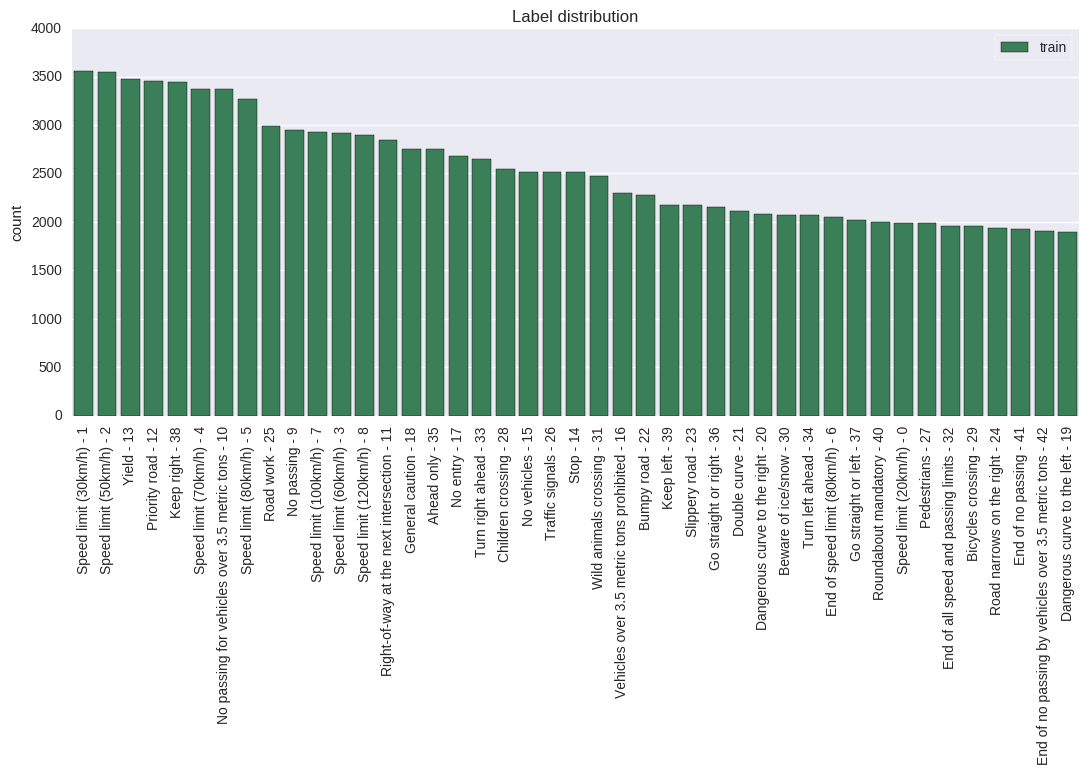

In [14]:
order_list = list(zip(*aug_data_distribution.most_common()))[0]
order = [int(indices) for indices in order_list]
f, ax = plt.subplots(figsize=(13, 5))
ax = sns.countplot(x=y_a, order=order, color='seagreen', ax=ax, label="train")

#ax = sns.countplot(x=y_test, order=order, color='lightblue', ax=ax, label="test")

_ = ax.set_title('Label distribution')
_ = ax.legend(ncol=2, loc="upper right", frameon=True)
_ = ax.set_xticklabels(['%s - %s'% (signnames[i], i) for i in order], rotation=90)

In [15]:
#normalize features so that all values are be
X_train = X_a.astype(np.float32)
X_valid = X_valid.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_a

X_train /= 255
X_valid /= 255
X_test /= 255

In [16]:
import os
# Save the data for easy access
pickle_file = '/home/shreyas/Documents/sdcND/data/traffic_signs.pickle'
if not os.path.isfile(pickle_file):
    print('Saving data to pickle file...')
    try:
        with open(pickle_file, 'wb') as pfile:
            pickle.dump(
                {
                    'train_dataset': X_train,
                    'train_labels': y_train,
                    'valid_dataset': X_valid,
                    'valid_labels': y_valid,
                    'test_dataset': X_test,
                    'test_labels': y_test,
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

print('Data cached in pickle file.')

Data cached in pickle file.


In [2]:
import pickle

pickle_file = '/home/shreyas/Documents/sdcND/data/traffic_signs.pickle'
with open(pickle_file, 'rb') as f:
  pickle_data = pickle.load(f)
  X_train = pickle_data['train_dataset']
  y_train = pickle_data['train_labels']
  X_valid = pickle_data['valid_dataset']
  y_valid = pickle_data['valid_labels']
  X_test = pickle_data['test_dataset']
  y_test = pickle_data['test_labels']
  del pickle_data  # Free up memory


print('Data and modules loaded.')

Data and modules loaded.


In [3]:
print (y_valid.shape, y_test.shape, y_train.shape)
print (X_valid.shape, X_test.shape, X_train.shape)

(7842,) (12630,) (109456,)
(7842, 32, 32, 3) (12630, 32, 32, 3) (109456, 32, 32, 3)


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
pickle_file = '/home/shreyas/Documents/sdcND/data/udacity_traffic_signs.pickle'
with open(pickle_file, 'rb') as f:
  pickle_data = pickle.load(f)
  X_train = pickle_data['train_dataset']
  y_train = pickle_data['train_labels']
  X_valid = pickle_data['valid_dataset']
  y_valid = pickle_data['valid_labels']
  X_test = pickle_data['test_dataset']
  y_test = pickle_data['test_labels']
  del pickle_data  # Free up memory


print('Data and modules loaded.')

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

In [4]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
def weights(shape):
    return tf.Variable(tf.truncated_normal(shape, mean=0.0, stddev=0.1))


def biases(length):
    return tf.Variable(tf.zeros(length))


def conv2d(x, nb_filter,
           filter_size=[1,1],  
           strides=[1,1,1,1],
           padding='SAME',
           batch_norm=False,  
           is_training=False):
    
    # get shape for weight tensor
    nb_channel = int(x.get_shape()[3])
    shape = [filter_size[0], filter_size[1], nb_channel, nb_filter]
    
    # initiate the weights
    W = weights(shape)
    # convolution
    layer = tf.nn.conv2d(x, W, strides=strides, padding=padding)
    
    # batch_normalisation   
    if batch_norm:
        layer = tf.contrib.layers.batch_norm(layer, scale=True, updates_collections=None, is_training=is_training)
    else:
        b = biases(nb_filter)
        layer = tf.add(layer, b)
        
    return layer



def flatten(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features], name='flatten')
    return layer_flat, num_features



def dense(x, 
          nb_input, 
          nb_output,
          batch_norm=False,
          is_training=False,
          relu=True):
    
    # get shape for weight tensor
    shape = [nb_input, nb_output]
    # intitiate weight matrix
    W = weights(shape)
    layer = tf.matmul(x,W)
    
    if batch_norm:
        layer = tf.contrib.layers.batch_norm(layer, scale=True, updates_collections=None, is_training=is_training)
    else:
        b = biases(nb_output)
        layer = tf.add(layer,b)
    # perform relu activation
    if relu:
        layer = tf.nn.relu(layer)
    
    return layer


def max_pool(x, ksize=[1,3,3,1], strides=[1,2,2,1], padding='SAME'):
    return tf.nn.max_pool(x, ksize=ksize, strides=strides, padding=padding)
    

def avg_pool(x, ksize=[1,3,3,1], strides=[1,2,2,1], padding='SAME'):
    return tf.nn.avg_pool(x, ksize=ksize, strides=strides, padding=padding)

def combined_pool(x):
    return tf.add(max_pool(x),avg_pool(x))

In [5]:
def model0(x, keep_prob, is_training):
    # learning color space 
    color_s1 = conv2d(X,10, batch_norm=False, is_training=is_training)
    color_s2 = conv2d(color_s1,3, batch_norm=False, is_training=is_training)
    
    # block 1 - convolution 
    conv1 = conv2d(color_s2, nb_filter=32, filter_size=[3,3], batch_norm=True, is_training=is_training)
    conv1 = tf.nn.relu(conv1)
    conv1 = conv2d(conv1, nb_filter=32, filter_size=[3,3], batch_norm=True, is_training=is_training)
    conv1 = tf.nn.relu(conv1)
    
    
    pool = max_pool(conv1)
    dropout1 = tf.nn.dropout(pool, keep_prob)
    
    # block 2 
    
    conv2 = conv2d(dropout1, nb_filter=64, filter_size=[3,3], batch_norm=True, is_training=is_training)
    conv2 = tf.nn.relu(conv2)
    conv2 = conv2d(conv2, nb_filter=64, filter_size=[3,3], batch_norm=True, is_training=is_training)
    conv2 = tf.nn.relu(conv2)
    
    
    pool = max_pool(conv2)
    dropout2 = tf.nn.dropout(pool, keep_prob)
    
    # block 3 
    conv3 = conv2d(dropout2, nb_filter=128, filter_size=[3,3], batch_norm=True, is_training=is_training)
    conv3 = tf.nn.relu(conv3)
    conv3 = conv2d(conv3, nb_filter=128, filter_size=[3,3], batch_norm=True, is_training=is_training)
    conv3 = tf.nn.relu(conv3)
    
    
    pool = max_pool(conv3)
    dropout3 = tf.nn.dropout(pool, keep_prob)
      
    # flatten the layer
    flat1, f1 = flatten(dropout1)
    flat2, f2 = flatten(dropout2)
    flat3, f3 = flatten(dropout3)
    
    net = tf.concat(1,[flat1, flat2, flat3])
    
    features = f1+f2+f3
    
    # frist dense layer
    fc1 = dense(net, features, 1024, batch_norm=True, is_training=is_training)
    dropout = tf.nn.dropout(fc1, keep_prob)
    
    fc2 = dense(fc1, 1024, 1024, batch_norm=True, is_training=is_training)
    dropout = tf.nn.dropout(fc2, keep_prob)
    
    # output layer
    output = dense(dropout, 1024, 43, relu=False) 
    return tf.nn.softmax(output)

In [6]:
def model1(x, keep_prob, is_training):
    # learning color space 
    color_s1 = conv2d(X,10, batch_norm=True, is_training=is_training)
    color_s2 = conv2d(color_s1,3, batch_norm=True, is_training=is_training)
    
    # block 1 - convolution 
    conv1x1 = conv2d(color_s2, nb_filter=64, filter_size=[1,1], batch_norm=True, is_training=is_training)
    conv1x1 = tf.nn.relu(conv1x1)
    conv5x5 = conv2d(conv1x1, nb_filter=64, filter_size=[5,5], batch_norm=True, is_training=is_training)
    conv5x5 = tf.nn.relu(conv5x5)
    conv1x1 = conv2d(conv5x5, nb_filter=128, filter_size=[1,1], batch_norm=True, is_training=is_training)
    conv1x1 = tf.nn.relu(conv1x1)
    
    pool = combined_pool(conv1x1)
    dropout = tf.nn.dropout(pool, keep_prob)
    
    # block 2 
    
    conv1x1 = conv2d(dropout, nb_filter=128, filter_size=[1,1], batch_norm=True, is_training=is_training)
    conv1x1 = tf.nn.relu(conv1x1)
    conv5x5 = conv2d(conv1x1, nb_filter=128, filter_size=[5,5], batch_norm=True, is_training=is_training)
    conv5x5 = tf.nn.relu(conv5x5)
    conv1x1 = conv2d(conv5x5, nb_filter=256, filter_size=[1,1], batch_norm=True, is_training=is_training)
    conv1x1 = tf.nn.relu(conv1x1)
    
    pool = combined_pool(conv1x1)
    dropout = tf.nn.dropout(pool, keep_prob)
    
    # block 3 
    conv1x1 = conv2d(dropout, nb_filter=128, filter_size=[1,1], batch_norm=True, is_training=is_training)
    conv1x1 = tf.nn.relu(conv1x1)
    conv3x3 = conv2d(conv1x1, nb_filter=128, filter_size=[3,3], batch_norm=True, is_training=is_training)
    conv3x3 = tf.nn.relu(conv3x3)
    conv1x1 = conv2d(conv3x3, nb_filter=256, filter_size=[1,1], batch_norm=True, is_training=is_training)
    conv1x1 = tf.nn.relu(conv1x1)
    
    pool = combined_pool(conv1x1)
    dropout = tf.nn.dropout(pool, keep_prob)
    
    # flatten the layer
    flat, features = flatten(dropout)
    
    # frist dense layer
    fc1 = dense(flat, features, 1024, batch_norm=True, is_training=is_training)
    dropout = tf.nn.dropout(fc1, keep_prob)
    
    fc2 = dense(fc1, 1024, 1024, batch_norm=True, is_training=is_training)
    dropout = tf.nn.dropout(fc2, keep_prob)
    
    # output layer
    output = dense(dropout, 1024, 43, relu=False) 
    return output

In [7]:
def model2(x, keep_prob, is_training):
    # learning color space 
    color_s1 = conv2d(X,10, batch_norm=True, is_training=is_training)
    color_s2 = conv2d(color_s1,3, batch_norm=True, is_training=is_training)
    
    # block 1 - convolution 
    conv1x1 = conv2d(color_s2, nb_filter=64, filter_size=[1,1], batch_norm=True, is_training=is_training)
    conv1x1 = tf.nn.relu(conv1x1)
    conv5x5 = conv2d(conv1x1, nb_filter=64, filter_size=[5,5], batch_norm=True, is_training=is_training)
    conv5x5 = tf.nn.relu(conv5x5)
    conv1x1 = conv2d(conv5x5, nb_filter=256, filter_size=[1,1], batch_norm=True, is_training=is_training)
    conv1x1 = tf.nn.relu(conv1x1)
    
    pool = combined_pool(conv1x1)
    dropout = tf.nn.dropout(pool, keep_prob)
    
    # block 2 
    
    conv1x1 = conv2d(dropout, nb_filter=128, filter_size=[1,1], batch_norm=True, is_training=is_training)
    conv1x1 = tf.nn.relu(conv1x1)
    conv5x5 = conv2d(conv1x1, nb_filter=128, filter_size=[5,5], batch_norm=True, is_training=is_training)
    conv5x5 = tf.nn.relu(conv5x5)
    conv1x1 = conv2d(conv5x5, nb_filter=256, filter_size=[1,1], batch_norm=True, is_training=is_training)
        
    net = tf.add(conv1x1, pool)
    net = tf.nn.relu(net)
    pool = combined_pool(net)
    dropout = tf.nn.dropout(pool, keep_prob)
    
    # block 3 
    
    conv1x1 = conv2d(dropout, nb_filter=128, filter_size=[1,1], batch_norm=True, is_training=is_training)
    conv1x1 = tf.nn.relu(conv1x1)
    conv3x3 = conv2d(conv1x1, nb_filter=128, filter_size=[3,3], batch_norm=True, is_training=is_training)
    conv3x3 = tf.nn.relu(conv3x3)
    conv1x1 = conv2d(conv3x3, nb_filter=256, filter_size=[1,1], batch_norm=True, is_training=is_training)
    
    net = tf.add(conv1x1, pool)
    net = tf.nn.relu(net)
    pool = combined_pool(net)
    dropout = tf.nn.dropout(pool, keep_prob)
    
    # flatten the layer
    flat, features = flatten(dropout)
    
    # frist dense layer
    fc1 = dense(flat, features, 4096, batch_norm=True, is_training=is_training)
    dropout = tf.nn.dropout(fc1, keep_prob)
          
    # output layer
    output = dense(dropout, 4096, 43, relu=False) 
    return output

In [8]:
def model3(x, keep_prob, is_training):
    # learning color space 
    color_s1 = conv2d(X,10, batch_norm=True, is_training=is_training)
    color_s2 = conv2d(color_s1,3, batch_norm=True, is_training=is_training)
    
    # block 1 - convolution 
    conv1x1 = conv2d(color_s2, nb_filter=64, filter_size=[1,1], batch_norm=True, is_training=is_training)
    conv1x1 = tf.nn.relu(conv1x1)
    conv5x5 = conv2d(conv1x1, nb_filter=64, filter_size=[5,5], batch_norm=True, is_training=is_training)
    conv5x5 = tf.nn.relu(conv5x5)
    conv1x1 = conv2d(conv5x5, nb_filter=256, filter_size=[1,1], batch_norm=True, is_training=is_training)
    conv1x1 = tf.nn.relu(conv1x1)
    
    pool = combined_pool(conv1x1)
    dropout = tf.nn.dropout(pool, keep_prob)
    
    # block 2 - inception
    branch_pool = avg_pool(conv1x1)
    branch_pool = conv2d(branch_pool, nb_filter=96, filter_size=[1,1], batch_norm=True, is_training=is_training)
    
    branch_conv1x1 = conv2d(dropout, nb_filter=96, filter_size=[1,1], batch_norm=True, is_training=is_training)
    conv1x1 = conv2d(dropout, nb_filter=64, filter_size=[1,1], batch_norm=True, is_training=is_training)
    branch_conv3x3 = conv2d(conv1x1, nb_filter=96, filter_size=[3,3], batch_norm=True, is_training=is_training)
    branch2_conv3x3 = conv2d(branch_conv3x3, nb_filter=96, filter_size=[3,3], batch_norm=True, is_training=is_training)
        
    net = tf.concat(3,[branch_pool, branch_conv1x1, branch_conv3x3, branch2_conv3x3])
    net = tf.nn.relu(net)
    pool = max_pool(net)
    dropout = tf.nn.dropout(pool, keep_prob)
    
    # block 3 - inception
    branch_pool = avg_pool(net)
    branch_pool = conv2d(branch_pool, nb_filter=96, filter_size=[1,1], batch_norm=True, is_training=is_training)
    
    branch_conv1x1 = conv2d(dropout, nb_filter=96, filter_size=[1,1], batch_norm=True, is_training=is_training)
    conv1x1 = conv2d(dropout, nb_filter=64, filter_size=[1,1], batch_norm=True, is_training=is_training)
    branch_conv3x3 = conv2d(conv1x1, nb_filter=96, filter_size=[3,3], batch_norm=True, is_training=is_training)
    branch_conv5x5 = conv2d(conv1x1, nb_filter=96, filter_size=[5,5], batch_norm=True, is_training=is_training)
    
    net = tf.concat(3,[branch_pool, branch_conv1x1, branch_conv3x3, branch_conv5x5])
    net = tf.nn.relu(net)
    pool = max_pool(net)
    dropout = tf.nn.dropout(pool, keep_prob)
    
    # flatten the layer
    flat, features = flatten(dropout)
    
    # frist dense layer
    fc1 = dense(flat, features, 4096, batch_norm=True, is_training=is_training)
    dropout = tf.nn.dropout(fc1, keep_prob)
        
    # output layer
    output = dense(dropout, 4096, 43, relu=False) 
    return output

In [9]:
def model4(x, keep_prob, is_training):
    # learning color space 
    color_s1 = conv2d(X,10, batch_norm=True, is_training=is_training)
    color_s2 = conv2d(color_s1,3, batch_norm=True, is_training=is_training)
    
    # block 1 - convolution 
    conv1x1 = conv2d(color_s2, nb_filter=64, filter_size=[1,1], batch_norm=True, is_training=is_training)
    conv1x1 = tf.nn.relu(conv1x1)
    conv5x5 = conv2d(conv1x1, nb_filter=64, filter_size=[5,5], batch_norm=True, is_training=is_training)
    conv5x5 = tf.nn.relu(conv5x5)
    conv1x1 = conv2d(conv5x5, nb_filter=384, filter_size=[1,1], batch_norm=True, is_training=is_training)
    conv1x1 = tf.nn.relu(conv1x1)
    
    pool = combined_pool(conv1x1)
    dropout = tf.nn.dropout(pool, keep_prob)
    
    # block 2 - inception
    branch_pool = avg_pool(conv1x1)
    branch_pool = conv2d(branch_pool, nb_filter=96, filter_size=[1,1], batch_norm=True, is_training=is_training)
    
    branch_conv1x1 = conv2d(dropout, nb_filter=96, filter_size=[1,1], batch_norm=True, is_training=is_training)
    conv1x1 = conv2d(dropout, nb_filter=64, filter_size=[1,1], batch_norm=True, is_training=is_training)
    branch_conv3x3 = conv2d(conv1x1, nb_filter=96, filter_size=[3,3], batch_norm=True, is_training=is_training)
    branch2_conv3x3 = conv2d(branch_conv3x3, nb_filter=96, filter_size=[3,3], batch_norm=True, is_training=is_training)
        
    net = tf.concat(3,[branch_pool, branch_conv1x1, branch_conv3x3, branch2_conv3x3])
    net = tf.add(pool,net)
    net = tf.nn.relu(net)
    pool = max_pool(net)
    dropout = tf.nn.dropout(pool, keep_prob)
    
    # block 3 - inception
    branch_pool = avg_pool(net)
    branch_pool = conv2d(branch_pool, nb_filter=96, filter_size=[1,1], batch_norm=True, is_training=is_training)
    
    branch_conv1x1 = conv2d(dropout, nb_filter=96, filter_size=[1,1], batch_norm=True, is_training=is_training)
    conv1x1 = conv2d(dropout, nb_filter=64, filter_size=[1,1], batch_norm=True, is_training=is_training)
    branch_conv3x3 = conv2d(conv1x1, nb_filter=96, filter_size=[3,3], batch_norm=True, is_training=is_training)
    branch_conv5x5 = conv2d(conv1x1, nb_filter=96, filter_size=[5,5], batch_norm=True, is_training=is_training)
    
    net = tf.concat(3,[branch_pool, branch_conv1x1, branch_conv3x3, branch_conv5x5])
    net = tf.add(pool,net)
    net = tf.nn.relu(net)
    pool = max_pool(net)
    dropout = tf.nn.dropout(pool, keep_prob)
    
    # flatten the layer
    flat, features = flatten(dropout)
    
    # frist dense layer
    fc1 = dense(flat, features, 4096, batch_norm=True, is_training=is_training)
    dropout = tf.nn.dropout(fc1, keep_prob)
   
    # output layer
    output = dense(dropout, 4096, 43, relu=False) 
    return output

In [10]:
def get_accuracy(y_pred, y):
    #y_pred = tf.nn.softmax(logits)
    correct_pred = tf.equal(tf.argmax(y_pred,1),y)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    return accuracy

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = X_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
        acc, cost = sess.run([accuracy,loss], feed_dict={X: batch_x, y: batch_y, keep_prob:1, is_training:False})
        total_accuracy += (acc * len(batch_x))
        total_loss += cost
    return total_accuracy/num_examples, total_loss/num_examples

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [11]:
# placeholder for input and outputs
X = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int64, (None))
keep_prob = tf.placeholder(tf.float32)
is_training = tf.placeholder(tf.bool, [])

In [12]:
### Train your model here.
### Feel free to use as many code cells as needed.
logits =model1(X, keep_prob, is_training)

cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits, y)
loss = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(3e-4).minimize(loss)

accuracy = get_accuracy(logits, y)

In [13]:
batch_size = 128 

Epoch  2/377:   0%|          | 1/856 [00:00<02:04,  6.89batches/s]

Validation accuracy at (0.0056108135679673555, 0.035784158679910597)


Epoch  3/377:   0%|          | 1/856 [00:00<02:06,  6.77batches/s]

Validation accuracy at (0.0056108135679673555, 0.06288981492408105)


Epoch  4/377:   0%|          | 1/856 [00:00<02:07,  6.71batches/s]

Validation accuracy at (0.0056108135679673555, 0.058623518210471633)


Epoch  5/377:   0%|          | 1/856 [00:00<02:03,  6.91batches/s]

Validation accuracy at (0.0068859984697781174, 0.057320273612658915)


Epoch  6/377:   0%|          | 1/856 [00:00<02:12,  6.47batches/s]

Validation accuracy at (0.11795460344409797, 0.046855197272657044)


Epoch  7/377:   0%|          | 1/856 [00:00<02:09,  6.62batches/s]

Validation accuracy at (0.39964294825029506, 0.024350105272024088)


Epoch  8/377:   0%|          | 1/856 [00:00<02:01,  7.06batches/s]

Validation accuracy at (0.62484060199368341, 0.014850410415456781)


Epoch  9/377:   0%|          | 1/856 [00:00<02:03,  6.91batches/s]

Validation accuracy at (0.83282325943341462, 0.0050727453494187492)


Epoch 10/377:   0%|          | 1/856 [00:00<02:02,  6.96batches/s]

Validation accuracy at (0.94095893921337692, 0.001590657930795528)


Epoch 11/377:   0%|          | 1/856 [00:00<01:57,  7.25batches/s]

Validation accuracy at (0.97436878348880507, 0.00071688713536741968)


Epoch 11/377: 100%|██████████| 856/856 [02:09<00:00,  6.61batches/s]


Validation accuracy at (0.96875797004244879, 0.00087042511444376369)


Epoch 13/377:   0%|          | 1/856 [00:00<01:59,  7.18batches/s]

Validation accuracy at (0.97003315482264851, 0.00076236397611560171)


Epoch 14/377:   0%|          | 1/856 [00:00<01:59,  7.16batches/s]

Validation accuracy at (0.98597296621689412, 0.00034675098721909906)


Epoch 15/377:   0%|          | 1/856 [00:00<01:59,  7.18batches/s]

Validation accuracy at (0.97118082121907678, 0.00081699856161953418)


Epoch 16/377:   0%|          | 1/856 [00:00<02:04,  6.89batches/s]

Validation accuracy at (0.96952308086192418, 0.0010559026334371567)


Epoch 17/377:   0%|          | 0/856 [00:00<?, ?batches/s]

Validation accuracy at (0.98699311413834268, 0.00038229706415702754)


Epoch 18/377:   0%|          | 1/856 [00:00<01:59,  7.15batches/s]

Validation accuracy at (0.99387911247130833, 0.00016112717804644749)


Epoch 19/377:   0%|          | 1/856 [00:00<01:59,  7.16batches/s]

Validation accuracy at (0.98099974509983212, 0.00075231121762854482)


Epoch 20/377:   0%|          | 1/856 [00:00<02:00,  7.08batches/s]

Validation accuracy at (0.99247640907931645, 0.00021174827405069175)


Epoch 21/377:   0%|          | 1/856 [00:00<02:00,  7.10batches/s]

Validation accuracy at (0.98508033664881411, 0.00041259595597008096)


Epoch 22/377:   0%|          | 1/856 [00:00<02:00,  7.10batches/s]

Validation accuracy at (0.98967100229533278, 0.0002530528229278401)


Epoch 23/377:   0%|          | 1/856 [00:00<01:57,  7.29batches/s]

Validation accuracy at (0.95422086216180613, 0.0025230651591671453)


Epoch 24/377:   0%|          | 1/856 [00:00<01:59,  7.13batches/s]

Validation accuracy at (0.991583779648049, 0.00023259281471959783)


Epoch 25/377:   0%|          | 1/856 [00:00<02:04,  6.87batches/s]

Validation accuracy at (0.9218311656558128, 0.0045744985516841729)


Epoch 26/377:   0%|          | 1/856 [00:00<02:06,  6.73batches/s]

Validation accuracy at (0.99311400153022189, 0.00018714579015565323)


Epoch 27/377:   0%|          | 1/856 [00:00<01:59,  7.16batches/s]

Validation accuracy at (0.99540933435348122, 0.00010514634461431569)


Epoch 28/377:   0%|          | 1/856 [00:00<02:00,  7.11batches/s]

Validation accuracy at (0.99273144619649112, 0.00021617589314159189)


Epoch 29/377:   0%|          | 1/856 [00:00<02:00,  7.11batches/s]

Validation accuracy at (0.99030859474623822, 0.00031367362740178118)


Epoch 30/377:   0%|          | 1/856 [00:00<01:57,  7.30batches/s]

Validation accuracy at (0.98469778131508334, 0.00068287101087562011)


Epoch 31/377:   0%|          | 1/856 [00:00<01:58,  7.23batches/s]

Validation accuracy at (0.99247640907931645, 0.00020992862780547957)


Epoch 31/377: 100%|██████████| 856/856 [02:07<00:00,  6.71batches/s]


Validation accuracy at (0.979979597041571, 0.0011490588157337062)


Epoch 33/377:   0%|          | 0/856 [00:00<?, ?batches/s]

Validation accuracy at (0.93509308863464469, 0.0051208814756659275)


Epoch 34/377:   0%|          | 1/856 [00:00<01:57,  7.26batches/s]

Validation accuracy at (0.94656975275094157, 0.0036742374903311749)


Epoch 35/377:   0%|          | 1/856 [00:00<01:58,  7.22batches/s]

Validation accuracy at (0.95077786280530596, 0.0026841861816031443)


Epoch 36/377:   0%|          | 1/856 [00:00<02:00,  7.12batches/s]

Validation accuracy at (0.9889058914910589, 0.0004617915894752372)


Epoch 37/377:   0%|          | 1/856 [00:00<02:00,  7.08batches/s]

Validation accuracy at (0.99757714868655956, 9.4255352425238879e-05)


Epoch 38/377:   0%|          | 1/856 [00:00<02:05,  6.84batches/s]

Validation accuracy at (0.99591940831420556, 0.00014130473739798978)


Epoch 39/377:   0%|          | 1/856 [00:00<02:00,  7.09batches/s]

Validation accuracy at (0.99681203788228556, 0.00012972221197711596)


Epoch 40/377:   0%|          | 1/856 [00:00<02:03,  6.94batches/s]

Validation accuracy at (0.99744963019637845, 7.2948515086584096e-05)


Epoch 41/377:   0%|          | 1/856 [00:00<02:06,  6.78batches/s]

Validation accuracy at (0.99681203774547311, 0.0001076909263642598)


Epoch 42/377:   0%|          | 1/856 [00:00<01:59,  7.15batches/s]

Validation accuracy at (0.98546289211935734, 0.00062211281417708423)


Epoch 43/377:   0%|          | 1/856 [00:00<01:57,  7.27batches/s]

Validation accuracy at (0.97934200472747812, 0.00089221080729540701)


Epoch 44/377:   0%|          | 1/856 [00:00<02:01,  7.02batches/s]

Validation accuracy at (0.996684519255292, 0.00010819798741432451)


Epoch 45/377:   0%|          | 1/856 [00:00<01:59,  7.13batches/s]

Validation accuracy at (0.99732211170619745, 6.8356862884439527e-05)


Epoch 46/377:   0%|          | 1/856 [00:00<01:56,  7.31batches/s]

Validation accuracy at (0.98457026282490223, 0.0005683359494687456)


Epoch 46/377: 100%|██████████| 856/856 [02:07<00:00,  6.70batches/s]


Validation accuracy at (0.97424126512023512, 0.0016273757353043226)


Epoch 48/377:   0%|          | 1/856 [00:00<01:59,  7.13batches/s]

Validation accuracy at (0.99795970415710278, 6.7998488392166073e-05)


Epoch 49/377:   0%|          | 0/856 [00:00<?, ?batches/s]

Validation accuracy at (0.98278500382555467, 0.00081112714468223345)


Epoch 50/377:   0%|          | 1/856 [00:00<01:57,  7.30batches/s]

Validation accuracy at (0.99630196378474878, 0.00011595247599252508)


Epoch 51/377:   0%|          | 1/856 [00:00<02:03,  6.93batches/s]

Validation accuracy at (0.99196633511859222, 0.00028894800794572901)


Epoch 52/377:   0%|          | 1/856 [00:00<01:59,  7.14batches/s]

Validation accuracy at (0.99413414945167045, 0.00017070413182525371)


Epoch 53/377:   0%|          | 1/856 [00:00<01:59,  7.17batches/s]

Validation accuracy at (0.99821474113746489, 5.218582156298476e-05)


Epoch 54/377:   0%|          | 1/856 [00:00<01:59,  7.18batches/s]

Validation accuracy at (0.97742922723794945, 0.0008546559993709463)


Epoch 55/377:   0%|          | 1/856 [00:00<01:58,  7.20batches/s]

Validation accuracy at (0.99477174190257589, 0.00017807764018979797)


Epoch 56/377:   0%|          | 1/856 [00:00<01:56,  7.32batches/s]

Validation accuracy at (0.99234889058913545, 0.0003136634044405642)


Epoch 57/377:   0%|          | 1/856 [00:00<01:58,  7.23batches/s]

Validation accuracy at (0.97615404233613878, 0.0013017089673524331)


Epoch 58/377:   0%|          | 1/856 [00:00<02:03,  6.90batches/s]

Validation accuracy at (0.96990563631726601, 0.001882748195868082)


Epoch 59/377:   0%|          | 1/856 [00:00<01:58,  7.24batches/s]

Validation accuracy at (0.99617444529456767, 0.00012134780795341679)


Epoch 60/377:   0%|          | 1/856 [00:00<01:59,  7.15batches/s]

Validation accuracy at (0.98903340984442745, 0.00036379005063013833)


Epoch 61/377:   0%|          | 1/856 [00:00<01:57,  7.25batches/s]

Validation accuracy at (0.99464422341239478, 0.00015679132374495089)


Epoch 62/377:   0%|          | 1/856 [00:00<01:58,  7.23batches/s]

Validation accuracy at (0.99795970415710278, 6.0530086577819734e-05)


Epoch 63/377:   0%|          | 1/856 [00:00<01:58,  7.22batches/s]

Validation accuracy at (0.988268298903341, 0.00042483630119573225)


Epoch 64/377:   0%|          | 1/856 [00:00<01:57,  7.27batches/s]

Validation accuracy at (0.99846977811782711, 4.881872003764176e-05)


Epoch 65/377:   0%|          | 0/856 [00:00<?, ?batches/s]

Validation accuracy at (0.98903340984442745, 0.00051837989908917628)


Epoch 66/377:   0%|          | 1/856 [00:00<01:57,  7.25batches/s]

Validation accuracy at (0.99732211170619745, 9.483621887057566e-05)


Epoch 67/377:   0%|          | 1/856 [00:00<01:58,  7.21batches/s]

Validation accuracy at (0.97704667190421879, 0.001593672276169513)


Epoch 68/377:   0%|          | 1/856 [00:00<01:57,  7.25batches/s]

Validation accuracy at (0.99630196378474878, 0.00011127144167767974)


Epoch 69/377:   0%|          | 1/856 [00:00<02:00,  7.11batches/s]

Validation accuracy at (0.99783218566692167, 7.3003463288016354e-05)


Epoch 70/377:   0%|          | 1/856 [00:00<01:59,  7.16batches/s]

Validation accuracy at (0.99859729660800811, 5.0435542093260825e-05)


Epoch 71/377:   0%|          | 1/856 [00:00<02:00,  7.12batches/s]

Validation accuracy at (0.99872481509818922, 6.5889401414430781e-05)


Epoch 72/377:   0%|          | 1/856 [00:00<01:59,  7.15batches/s]

Validation accuracy at (0.98775822507942923, 0.00050482454560223664)


Epoch 73/377:   0%|          | 1/856 [00:00<01:58,  7.24batches/s]

Validation accuracy at (0.98673807715798056, 0.00055408560985801094)


Epoch 74/377:   0%|          | 1/856 [00:00<02:00,  7.10batches/s]

Validation accuracy at (0.98686559551134911, 0.00059296081952531611)


Epoch 75/377:   0%|          | 1/856 [00:00<02:00,  7.12batches/s]

Validation accuracy at (0.97500637606132157, 0.0016916857099824455)


Epoch 76/377:   0%|          | 1/856 [00:00<02:00,  7.11batches/s]

Validation accuracy at (0.98252996684519256, 0.00088718009377728845)


Epoch 77/377:   0%|          | 1/856 [00:00<02:00,  7.08batches/s]

Validation accuracy at (0.99056363172660034, 0.00033456043924873105)


Epoch 78/377:   0%|          | 1/856 [00:00<02:00,  7.07batches/s]

Validation accuracy at (0.99808722264728389, 6.0258356810888004e-05)


Epoch 79/377:   0%|          | 1/856 [00:00<01:57,  7.29batches/s]

Validation accuracy at (0.99872481509818922, 4.6069023896412839e-05)


Epoch 80/377:   0%|          | 1/856 [00:00<02:00,  7.08batches/s]

Validation accuracy at (0.99604692694119912, 0.00017899541197181752)


Epoch 81/377:   0%|          | 0/856 [00:00<?, ?batches/s]

Validation accuracy at (0.99489926052956945, 0.00017448505776963434)


Epoch 82/377:   0%|          | 1/856 [00:00<01:57,  7.29batches/s]

Validation accuracy at (0.9714358581994389, 0.0018001819844324326)


Epoch 83/377:   0%|          | 1/856 [00:00<01:58,  7.24batches/s]

Validation accuracy at (0.96505993369038512, 0.0024788876409281573)


Epoch 84/377:   0%|          | 1/856 [00:00<01:57,  7.25batches/s]

Validation accuracy at (0.99540933435348122, 0.00015430036316532462)


Epoch 85/377:   0%|          | 1/856 [00:00<02:01,  7.05batches/s]

Validation accuracy at (0.99030859474623822, 0.00037989444550206149)


Epoch 86/377:   0%|          | 1/856 [00:00<02:00,  7.10batches/s]

Validation accuracy at (0.99846977811782711, 3.0365663530265324e-05)


Epoch 87/377:   0%|          | 1/856 [00:00<01:58,  7.23batches/s]

Validation accuracy at (0.99553685284366233, 0.00014615443193968767)


Epoch 88/377:   0%|          | 1/856 [00:00<01:57,  7.26batches/s]

Validation accuracy at (0.9697781178270849, 0.0019433458059349507)


Epoch 89/377:   0%|          | 1/856 [00:00<01:56,  7.35batches/s]

Validation accuracy at (0.99311400166703434, 0.00030012454320893587)


Epoch 90/377:   0%|          | 1/856 [00:00<02:00,  7.10batches/s]

Validation accuracy at (0.99897985207855144, 3.2560708939071524e-05)


Epoch 91/377:   0%|          | 1/856 [00:00<01:58,  7.19batches/s]

Validation accuracy at (0.96710022967009479, 0.0019704601949508838)


Epoch 92/377:   0%|          | 1/856 [00:00<02:00,  7.10batches/s]

Validation accuracy at (0.97628156096313234, 0.0016826492762102825)


Epoch 93/377:   0%|          | 1/856 [00:00<01:58,  7.23batches/s]

Validation accuracy at (0.99196633525540467, 0.0003592061418082729)


Epoch 94/377:   0%|          | 1/856 [00:00<01:58,  7.21batches/s]

Validation accuracy at (0.97475133908095934, 0.0016371798660018042)


Epoch 95/377:   0%|          | 1/856 [00:00<01:58,  7.24batches/s]

Validation accuracy at (0.99885233358837033, 4.0877410928087742e-05)


Epoch 96/377:   0%|          | 1/856 [00:00<01:59,  7.14batches/s]

Validation accuracy at (0.99260392756949756, 0.00041613997182774289)


Epoch 97/377:   0%|          | 0/856 [00:00<?, ?batches/s]

Validation accuracy at (0.99515429737311911, 0.00015704859168430945)


Epoch 98/377:   0%|          | 1/856 [00:00<01:59,  7.14batches/s]

Validation accuracy at (0.99859729660800811, 5.6264833924483838e-05)


Epoch 99/377:   0%|          | 1/856 [00:00<01:56,  7.33batches/s]

Validation accuracy at (0.99770466717674067, 8.3778685540788223e-05)


Epoch 100/377:   0%|          | 1/856 [00:00<01:58,  7.20batches/s]

Validation accuracy at (0.99706707472583522, 9.2927009447862346e-05)


Epoch 101/377:   0%|          | 1/856 [00:00<02:00,  7.10batches/s]

Validation accuracy at (0.99821474127427745, 7.621036901652753e-05)


Epoch 102/377:   0%|          | 1/856 [00:00<01:58,  7.21batches/s]

Validation accuracy at (0.99846977811782711, 4.7361667405131096e-05)


Epoch 103/377:   0%|          | 1/856 [00:00<02:01,  7.03batches/s]

Validation accuracy at (0.98342259627646011, 0.0012184066140552233)


Epoch 104/377:   0%|          | 1/856 [00:00<01:59,  7.13batches/s]

Validation accuracy at (0.99681203774547311, 0.00012222902320512777)


Epoch 105/377:   0%|          | 1/856 [00:00<01:57,  7.25batches/s]

Validation accuracy at (0.99923488905891356, 3.7714980185992998e-05)


Epoch 106/377:   0%|          | 1/856 [00:00<01:59,  7.17batches/s]

Validation accuracy at (0.99260392756949756, 0.00029847310690975188)


Epoch 107/377:   0%|          | 1/856 [00:00<02:01,  7.06batches/s]

Validation accuracy at (0.99910737056873244, 4.4232469898833846e-05)


Epoch 108/377:   0%|          | 1/856 [00:00<01:59,  7.17batches/s]

Validation accuracy at (0.99872481509818922, 6.7745375209979998e-05)


Epoch 109/377:   0%|          | 1/856 [00:00<01:57,  7.30batches/s]

Validation accuracy at (0.99273144605967867, 0.000229953214252954)


Epoch 110/377:   0%|          | 1/856 [00:00<01:59,  7.16batches/s]

Validation accuracy at (0.99642948227492989, 0.00013604772211111795)


Epoch 111/377:   0%|          | 1/856 [00:00<02:00,  7.10batches/s]

Validation accuracy at (0.99617444529456767, 0.00022789241988043263)


Epoch 112/377:   0%|          | 1/856 [00:00<02:00,  7.09batches/s]

Validation accuracy at (0.99872481509818922, 6.4360214284613871e-05)


Epoch 113/377:   0%|          | 0/856 [00:00<?, ?batches/s]

Validation accuracy at (0.998342259627646, 0.00010027402888586401)


Epoch 114/377:   0%|          | 1/856 [00:00<02:01,  7.04batches/s]

Validation accuracy at (0.99681203774547311, 0.00014708756007409312)


Epoch 115/377:   0%|          | 1/856 [00:00<01:59,  7.14batches/s]

Validation accuracy at (0.993241520020403, 0.00029559165183227424)


Epoch 116/377:   0%|          | 1/856 [00:00<01:59,  7.17batches/s]

Validation accuracy at (0.99744963019637845, 0.00010028430865325401)


Epoch 117/377:   0%|          | 1/856 [00:00<01:59,  7.14batches/s]

Validation accuracy at (0.98903340984442745, 0.00062285341155558717)


Epoch 118/377:   0%|          | 1/856 [00:00<01:57,  7.27batches/s]

Validation accuracy at (0.99872481509818922, 3.8506531926015279e-05)


Epoch 119/377:   0%|          | 1/856 [00:00<02:00,  7.12batches/s]

Validation accuracy at (0.97347615417914868, 0.0020744927883710172)


Epoch 120/377:   0%|          | 1/856 [00:00<02:01,  7.04batches/s]

Validation accuracy at (0.96850293306208668, 0.0022216189702085865)


Epoch 121/377:   0%|          | 1/856 [00:00<01:57,  7.28batches/s]

Validation accuracy at (0.99604692680438667, 0.00014311084744879761)


Epoch 122/377:   0%|          | 1/856 [00:00<01:57,  7.25batches/s]

Validation accuracy at (0.99872481509818922, 2.4758002769653331e-05)


Epoch 123/377:   0%|          | 1/856 [00:00<01:58,  7.19batches/s]

Validation accuracy at (0.99285896454985978, 0.00033588029521415921)


Epoch 124/377:   0%|          | 1/856 [00:00<01:59,  7.13batches/s]

Validation accuracy at (0.99642948227492989, 0.00012555685075952473)


Epoch 125/377:   0%|          | 1/856 [00:00<01:56,  7.32batches/s]

Validation accuracy at (0.99808722264728389, 7.2406259505527131e-05)


Epoch 126/377:   0%|          | 1/856 [00:00<01:58,  7.21batches/s]

Validation accuracy at (0.99846977811782711, 6.5463575168532776e-05)


Epoch 127/377:   0%|          | 1/856 [00:00<01:58,  7.19batches/s]

Validation accuracy at (0.99859729660800811, 9.0916786280865417e-05)


Epoch 128/377:   0%|          | 1/856 [00:00<01:59,  7.13batches/s]

Validation accuracy at (0.99923488905891356, 2.6538087861532742e-05)


Epoch 129/377:   0%|          | 0/856 [00:00<?, ?batches/s]

Validation accuracy at (0.99872481509818922, 4.7529757410594169e-05)


Epoch 130/377:   0%|          | 1/856 [00:00<02:00,  7.10batches/s]

Validation accuracy at (0.99273144605967867, 0.00037003756477199895)


Epoch 131/377:   0%|          | 1/856 [00:00<01:58,  7.24batches/s]

Validation accuracy at (0.97768426435512412, 0.0022937510317604763)


Epoch 132/377:   0%|          | 1/856 [00:00<01:58,  7.19batches/s]

Validation accuracy at (0.99846977811782711, 4.6638694975772802e-05)


Epoch 133/377:   0%|          | 1/856 [00:00<01:59,  7.14batches/s]

Validation accuracy at (0.998342259627646, 4.9095330358461849e-05)


Epoch 134/377:   0%|          | 1/856 [00:00<01:58,  7.19batches/s]

Validation accuracy at (0.99681203774547311, 9.6685367416125207e-05)


Epoch 135/377:   0%|          | 1/856 [00:00<02:00,  7.12batches/s]

Validation accuracy at (0.99553685284366233, 0.00018835312676194029)


Epoch 136/377:   0%|          | 1/856 [00:00<02:01,  7.06batches/s]

Validation accuracy at (0.99770466717674067, 6.8062555071382561e-05)


Epoch 137/377:   0%|          | 1/856 [00:00<02:00,  7.07batches/s]

Validation accuracy at (0.99885233358837033, 3.0331431422503626e-05)


Epoch 138/377:   0%|          | 1/856 [00:00<02:01,  7.04batches/s]

Validation accuracy at (0.99795970415710278, 5.33402857826417e-05)


Epoch 139/377:   0%|          | 1/856 [00:00<02:02,  6.97batches/s]

Validation accuracy at (0.98189237453109968, 0.001407213859024943)


Epoch 140/377:   0%|          | 1/856 [00:00<02:04,  6.87batches/s]

Validation accuracy at (0.99744963019637845, 8.524007289935996e-05)


Epoch 141/377:   0%|          | 1/856 [00:00<02:04,  6.87batches/s]

Validation accuracy at (0.97768426435512412, 0.0017134955164250783)


Epoch 142/377:   0%|          | 1/856 [00:00<01:59,  7.14batches/s]

Validation accuracy at (0.99885233358837033, 4.2862567351777433e-05)


Epoch 143/377:   0%|          | 1/856 [00:00<01:56,  7.32batches/s]

Validation accuracy at (0.98342259627646011, 0.0010147776253385625)


Epoch 144/377:   0%|          | 1/856 [00:00<02:01,  7.05batches/s]

Validation accuracy at (0.99591940845101801, 0.00014493745768559468)


Epoch 145/377:   0%|          | 0/856 [00:00<?, ?batches/s]

Validation accuracy at (0.99872481509818922, 3.914588269808662e-05)


Epoch 146/377:   0%|          | 1/856 [00:00<01:59,  7.13batches/s]

Validation accuracy at (0.99209385374558579, 0.00050294852937509489)


Epoch 147/377:   0%|          | 1/856 [00:00<01:59,  7.14batches/s]

Validation accuracy at (0.9246365723181853, 0.009854921988916774)


Epoch 148/377:   0%|          | 1/856 [00:00<02:00,  7.09batches/s]

Validation accuracy at (0.99923488905891356, 6.2394949652950501e-05)


Epoch 149/377:   0%|          | 1/856 [00:00<01:57,  7.25batches/s]

Validation accuracy at (0.96403978590574901, 0.0030346461846869955)


Epoch 150/377:   0%|          | 1/856 [00:00<01:59,  7.16batches/s]

Validation accuracy at (0.998342259627646, 6.7069008745412859e-05)


Epoch 151/377:   0%|          | 1/856 [00:00<01:55,  7.38batches/s]

Validation accuracy at (0.99744963019637845, 6.7939489636660808e-05)


Epoch 152/377:   0%|          | 1/856 [00:00<01:58,  7.23batches/s]

Validation accuracy at (0.99923488905891356, 4.0930427107239464e-05)


Epoch 153/377:   0%|          | 1/856 [00:00<01:59,  7.16batches/s]

Validation accuracy at (0.99859729660800811, 3.3845000230591444e-05)


Epoch 154/377:   0%|          | 1/856 [00:00<01:59,  7.14batches/s]

Validation accuracy at (0.98355011490345368, 0.0012027147576768856)


Epoch 155/377:   0%|          | 1/856 [00:00<02:00,  7.12batches/s]

Validation accuracy at (0.99770466717674067, 0.00010068520616755592)


Epoch 156/377:   0%|          | 1/856 [00:00<02:05,  6.82batches/s]

Validation accuracy at (0.99808722264728389, 5.6876517684366162e-05)


Epoch 157/377:   0%|          | 1/856 [00:00<02:02,  6.96batches/s]

Validation accuracy at (0.99923488905891356, 2.3865218443590449e-05)


Epoch 158/377:   0%|          | 1/856 [00:00<02:03,  6.90batches/s]

Validation accuracy at (0.99846977811782711, 5.991741820587734e-05)


Epoch 159/377:   0%|          | 1/856 [00:00<02:02,  7.00batches/s]

Validation accuracy at (0.99732211170619745, 0.00011097955493215174)


Epoch 160/377:   0%|          | 1/856 [00:00<02:01,  7.06batches/s]

Validation accuracy at (0.99808722264728389, 9.1763251295462895e-05)


Epoch 161/377:   0%|          | 0/856 [00:00<?, ?batches/s]

Validation accuracy at (0.99056363172660034, 0.00047525569675625447)


Epoch 162/377:   0%|          | 1/856 [00:00<01:59,  7.14batches/s]

Validation accuracy at (0.98699311400153023, 0.00068969073371031859)


Epoch 163/377:   0%|          | 1/856 [00:00<01:59,  7.14batches/s]

Validation accuracy at (0.97334863568896757, 0.0025057770955566327)


Epoch 164/377:   0%|          | 1/856 [00:00<01:57,  7.25batches/s]

Validation accuracy at (0.99923488905891356, 2.4166589573053625e-05)


Epoch 165/377:   0%|          | 1/856 [00:00<02:03,  6.91batches/s]

Validation accuracy at (0.99923488905891356, 3.4181482894555997e-05)


Epoch 166/377:   0%|          | 1/856 [00:00<02:02,  6.99batches/s]

Validation accuracy at (0.99783218566692167, 5.4817935413394841e-05)


Epoch 167/377:   0%|          | 1/856 [00:00<02:05,  6.84batches/s]

Validation accuracy at (0.99591940831420556, 0.00018262284377224219)


Epoch 168/377:   0%|          | 1/856 [00:00<02:05,  6.79batches/s]

Validation accuracy at (0.99081866870696256, 0.00049964361810483622)


Epoch 169/377:   0%|          | 1/856 [00:00<02:02,  6.96batches/s]

Validation accuracy at (0.99795970415710278, 6.5161426036737269e-05)


Epoch 170/377:   0%|          | 1/856 [00:00<01:57,  7.25batches/s]

Validation accuracy at (0.99821474113746489, 5.7708716335087856e-05)


Epoch 171/377:   0%|          | 1/856 [00:00<01:59,  7.14batches/s]

Validation accuracy at (0.99630196378474878, 0.00013275004475843562)


Epoch 172/377:   0%|          | 1/856 [00:00<01:59,  7.16batches/s]

Validation accuracy at (0.97092578437552712, 0.0019146997855206179)


Epoch 173/377:   0%|          | 1/856 [00:00<01:57,  7.27batches/s]

Validation accuracy at (0.99885233358837033, 5.8926067795436967e-05)


Epoch 174/377:   0%|          | 1/856 [00:00<02:04,  6.86batches/s]

Validation accuracy at (0.99885233358837033, 5.2811265725239914e-05)


Epoch 175/377:   0%|          | 1/856 [00:00<02:03,  6.93batches/s]

Validation accuracy at (0.98112726345320067, 0.0013849860667754523)


Epoch 176/377:   0%|          | 1/856 [00:00<02:00,  7.08batches/s]

Validation accuracy at (0.99846977811782711, 7.125288049087795e-05)


Epoch 177/377:   0%|          | 0/856 [00:00<?, ?batches/s]

Validation accuracy at (0.99719459321601633, 0.00013524379617951162)


Epoch 178/377:   0%|          | 1/856 [00:00<01:59,  7.18batches/s]

Validation accuracy at (0.99885233358837033, 3.6955789664208664e-05)


Epoch 179/377:   0%|          | 1/856 [00:00<02:01,  7.05batches/s]

Validation accuracy at (0.98533537362917623, 0.00092060083674539047)


Epoch 180/377:   0%|          | 1/856 [00:00<01:59,  7.17batches/s]

Validation accuracy at (0.92871716412559091, 0.0068167311687367333)


Epoch 181/377:   0%|          | 1/856 [00:00<01:59,  7.15batches/s]

Validation accuracy at (0.99948992603927567, 1.7612483685377276e-05)


Epoch 182/377:   0%|          | 1/856 [00:00<01:56,  7.35batches/s]

Validation accuracy at (0.99566437133384345, 0.00023746550237155645)


Epoch 183/377:   0%|          | 1/856 [00:00<01:56,  7.36batches/s]

Validation accuracy at (0.97883193076675379, 0.0013951408135071789)


Epoch 184/377:   0%|          | 1/856 [00:00<01:56,  7.35batches/s]

Validation accuracy at (0.99744963019637845, 0.00013620200307031116)


Epoch 185/377:   0%|          | 1/856 [00:00<01:59,  7.17batches/s]

Validation accuracy at (0.95409334367162502, 0.0048484020761706582)


Epoch 186/377:   0%|          | 1/856 [00:00<01:58,  7.24batches/s]

Validation accuracy at (0.99859729660800811, 5.1822553338502615e-05)


Epoch 187/377:   0%|          | 1/856 [00:00<01:57,  7.30batches/s]

Validation accuracy at (0.99821474113746489, 7.4163893501323888e-05)


Epoch 188/377:   0%|          | 1/856 [00:00<01:57,  7.29batches/s]

Validation accuracy at (0.99795970415710278, 8.0010499203624457e-05)


Epoch 189/377:   0%|          | 1/856 [00:00<02:00,  7.09batches/s]

Validation accuracy at (0.99872481509818922, 3.5405192098533163e-05)


Epoch 190/377:   0%|          | 1/856 [00:00<01:58,  7.23batches/s]

Validation accuracy at (0.99923488905891356, 2.7040515803359116e-05)


Epoch 191/377:   0%|          | 1/856 [00:00<01:58,  7.23batches/s]

Validation accuracy at (0.97462382045396578, 0.0017354891815099384)


Epoch 192/377:   0%|          | 1/856 [00:00<01:57,  7.30batches/s]

Validation accuracy at (0.97666411643367557, 0.0022027553367174623)


Epoch 193/377:   0%|          | 0/856 [00:00<?, ?batches/s]

Validation accuracy at (0.99770466717674067, 0.00011924680313677025)


Epoch 194/377:   0%|          | 1/856 [00:00<02:00,  7.10batches/s]

Validation accuracy at (0.99846977811782711, 5.5770145633660055e-05)


Epoch 195/377:   0%|          | 1/856 [00:00<01:57,  7.31batches/s]

Validation accuracy at (0.99821474113746489, 7.5194453653192687e-05)


Epoch 196/377:   0%|          | 1/856 [00:00<02:02,  6.95batches/s]

Validation accuracy at (0.99885233358837033, 4.9764025143241371e-05)


Epoch 197/377:   0%|          | 1/856 [00:00<01:58,  7.21batches/s]

Validation accuracy at (0.99885233358837033, 3.8629401856460149e-05)


Epoch 198/377:   0%|          | 1/856 [00:00<02:00,  7.12batches/s]

Validation accuracy at (0.99795970415710278, 0.00015819749649615932)


Epoch 199/377:   0%|          | 1/856 [00:00<01:54,  7.49batches/s]

Validation accuracy at (0.99897985207855144, 6.3558057676166798e-05)


Epoch 200/377:   0%|          | 1/856 [00:00<02:02,  7.00batches/s]

Validation accuracy at (0.99808722264728389, 6.3593555390654811e-05)


Epoch 201/377:   0%|          | 1/856 [00:00<02:02,  6.96batches/s]

Validation accuracy at (0.99821474113746489, 6.2792392713137405e-05)


Epoch 202/377:   0%|          | 1/856 [00:00<02:07,  6.71batches/s]

Validation accuracy at (0.99872481509818922, 5.897216239443084e-05)


Epoch 203/377:   0%|          | 1/856 [00:00<02:04,  6.87batches/s]

Validation accuracy at (0.988268298903341, 0.00074246903124415261)


Epoch 204/377:   0%|          | 1/856 [00:00<02:02,  6.98batches/s]

Validation accuracy at (0.97768426421831167, 0.0019535511602117692)


Epoch 205/377:   0%|          | 1/856 [00:00<02:05,  6.83batches/s]

Validation accuracy at (0.99426166794185156, 0.00032778935044491694)


Epoch 206/377:   0%|          | 1/856 [00:00<01:57,  7.25batches/s]

Validation accuracy at (0.99247640907931645, 0.00041032497814146924)


Epoch 207/377:   0%|          | 1/856 [00:00<01:52,  7.59batches/s]

Validation accuracy at (0.99757714868655956, 0.0001149371630319064)


Epoch 208/377:   0%|          | 1/856 [00:00<01:59,  7.18batches/s]

Validation accuracy at (0.996684519255292, 0.00019355585012480384)


Epoch 209/377:   0%|          | 0/856 [00:00<?, ?batches/s]

Validation accuracy at (0.99885233358837033, 4.9517146780123456e-05)


Epoch 210/377:   0%|          | 1/856 [00:00<01:58,  7.24batches/s]

Validation accuracy at (0.99285896468667223, 0.00044814639577473049)


Epoch 211/377:   0%|          | 1/856 [00:00<01:56,  7.35batches/s]

Validation accuracy at (0.99757714868655956, 0.00012271978901736569)


Epoch 212/377:   0%|          | 1/856 [00:00<01:57,  7.30batches/s]

Validation accuracy at (0.98877837286406534, 0.00079671838029487727)


Epoch 213/377:   0%|          | 1/856 [00:00<01:57,  7.27batches/s]

Validation accuracy at (0.99872481509818922, 3.9045054492744379e-05)


Epoch 214/377:   0%|          | 1/856 [00:00<01:57,  7.30batches/s]

Validation accuracy at (0.98329507792309145, 0.0010751407687495994)


Epoch 215/377:   0%|          | 1/856 [00:00<01:56,  7.32batches/s]

Validation accuracy at (0.99897985207855144, 4.2709888979093369e-05)


Epoch 216/377:   0%|          | 1/856 [00:00<01:57,  7.26batches/s]

Validation accuracy at (0.99846977811782711, 9.434308972996734e-05)


Epoch 217/377:   0%|          | 1/856 [00:00<01:57,  7.30batches/s]

Validation accuracy at (0.99923488905891356, 4.4058127283609505e-05)


Epoch 218/377:   0%|          | 1/856 [00:00<01:57,  7.28batches/s]

Validation accuracy at (0.99795970415710278, 0.00010546931634012597)


Epoch 219/377:   0%|          | 1/856 [00:00<02:02,  6.98batches/s]

Validation accuracy at (0.99872481509818922, 3.7075221490825856e-05)


Epoch 220/377:   0%|          | 1/856 [00:00<01:59,  7.13batches/s]

Validation accuracy at (0.99783218566692167, 6.3131510636960195e-05)


Epoch 221/377:   0%|          | 1/856 [00:00<01:59,  7.13batches/s]

Validation accuracy at (0.99948992603927567, 2.193903302113163e-05)


Epoch 222/377:   0%|          | 1/856 [00:00<01:58,  7.24batches/s]

Validation accuracy at (0.9419790871044228, 0.011201661455406275)


Epoch 223/377:   0%|          | 1/856 [00:00<01:56,  7.31batches/s]

Validation accuracy at (0.99744963019637845, 0.00010588738168201698)


Epoch 224/377:   0%|          | 1/856 [00:00<01:57,  7.27batches/s]

Validation accuracy at (0.99591940831420556, 0.00027161928905277625)


Epoch 225/377:   0%|          | 0/856 [00:00<?, ?batches/s]

Validation accuracy at (0.99706707486264778, 0.00016124197265492927)


Epoch 226/377:   0%|          | 1/856 [00:00<01:58,  7.24batches/s]

Validation accuracy at (0.99923488905891356, 2.2042700440241564e-05)


Epoch 227/377:   0%|          | 1/856 [00:00<01:57,  7.27batches/s]

Validation accuracy at (0.98597296608008156, 0.00069334128135896021)


Epoch 228/377:   0%|          | 1/856 [00:00<01:56,  7.33batches/s]

Validation accuracy at (0.98954348380515178, 0.00077499669785175936)


Epoch 229/377:   0%|          | 1/856 [00:00<01:57,  7.26batches/s]

Validation accuracy at (0.98087222647283856, 0.0014845337645202788)


Epoch 230/377:   0%|          | 1/856 [00:00<01:57,  7.28batches/s]

Validation accuracy at (0.99872481509818922, 4.1434850933526411e-05)


Epoch 231/377:   0%|          | 1/856 [00:00<02:03,  6.91batches/s]

Validation accuracy at (0.99923488905891356, 4.6487343325240095e-05)


Epoch 232/377:   0%|          | 1/856 [00:00<01:57,  7.30batches/s]

Validation accuracy at (0.99247640907931645, 0.00062610968525199915)


Epoch 232/377: 100%|██████████| 856/856 [02:07<00:00,  6.70batches/s]


Validation accuracy at (0.99948992603927567, 1.9374166325404995e-05)


Epoch 234/377:   0%|          | 1/856 [00:00<01:55,  7.37batches/s]

Validation accuracy at (0.99540933435348122, 0.00020373448898843176)


Epoch 235/377:   0%|          | 1/856 [00:00<02:06,  6.75batches/s]

Validation accuracy at (0.99923488905891356, 3.5375308873790774e-05)


Epoch 236/377:   0%|          | 1/856 [00:00<01:57,  7.25batches/s]

Validation accuracy at (0.96812037759154346, 0.0032266371893808258)


Epoch 237/377:   0%|          | 1/856 [00:00<01:58,  7.19batches/s]

Validation accuracy at (0.99885233358837033, 6.4775095385351258e-05)


Epoch 238/377:   0%|          | 1/856 [00:00<02:04,  6.88batches/s]

Validation accuracy at (0.96021423120031668, 0.0057444392179263181)


Epoch 239/377:   0%|          | 1/856 [00:00<02:00,  7.11batches/s]

Validation accuracy at (0.99923488905891356, 5.4845674784711717e-05)


Epoch 240/377:   0%|          | 1/856 [00:00<01:58,  7.19batches/s]

Validation accuracy at (0.99885233358837033, 3.3401559674926081e-05)


Epoch 241/377:   0%|          | 0/856 [00:00<?, ?batches/s]

Validation accuracy at (0.97067074725835245, 0.0026745246469053259)


Epoch 242/377:   0%|          | 1/856 [00:00<01:58,  7.19batches/s]

Validation accuracy at (0.98597296621689412, 0.0012440024609171639)


Epoch 243/377:   0%|          | 1/856 [00:00<02:02,  6.99batches/s]

Validation accuracy at (0.99859729660800811, 5.7326742187984952e-05)


Epoch 244/377:   0%|          | 1/856 [00:00<01:59,  7.18batches/s]

Validation accuracy at (0.99757714868655956, 0.0002153998237847386)


Epoch 245/377:   0%|          | 1/856 [00:00<02:01,  7.03batches/s]

Validation accuracy at (0.99910737056873244, 4.4837374667068073e-05)


Epoch 246/377:   0%|          | 1/856 [00:00<02:00,  7.11batches/s]

Validation accuracy at (0.98954348380515178, 0.0008966389359834528)


Epoch 247/377:   0%|          | 1/856 [00:00<01:57,  7.25batches/s]

Validation accuracy at (0.99477174190257589, 0.00026187100772009019)


Epoch 248/377:   0%|          | 1/856 [00:00<01:58,  7.19batches/s]

Validation accuracy at (0.99961744452945678, 2.2604581763620827e-05)


Epoch 249/377:   0%|          | 1/856 [00:00<01:59,  7.18batches/s]

Validation accuracy at (0.95026778882938023, 0.004522304514741767)


Epoch 250/377:   0%|          | 1/856 [00:00<01:59,  7.15batches/s]

Validation accuracy at (0.99375159398112722, 0.00028617542128458507)


Epoch 251/377:   0%|          | 1/856 [00:00<02:04,  6.87batches/s]

Validation accuracy at (0.99438918643203267, 0.00030914626524189772)


Epoch 252/377:   0%|          | 1/856 [00:00<01:59,  7.16batches/s]

Validation accuracy at (0.99936240754909467, 4.7562383362458358e-05)


Epoch 253/377:   0%|          | 1/856 [00:00<01:59,  7.15batches/s]

Validation accuracy at (0.995026778882938, 0.00022821646894307092)


Epoch 254/377:   0%|          | 1/856 [00:00<02:04,  6.88batches/s]

Validation accuracy at (0.99859729660800811, 5.1002587947125445e-05)


Epoch 255/377:   0%|          | 1/856 [00:00<02:04,  6.87batches/s]

Validation accuracy at (0.99923488905891356, 4.1576935577840843e-05)


Epoch 256/377:   0%|          | 1/856 [00:00<01:58,  7.21batches/s]

Validation accuracy at (0.99923488905891356, 1.7093152153697533e-05)


Epoch 257/377:   0%|          | 0/856 [00:00<?, ?batches/s]

Validation accuracy at (0.96582504476828401, 0.0030080123854804861)


Epoch 258/377:   0%|          | 1/856 [00:00<01:58,  7.21batches/s]

Validation accuracy at (0.99846977811782711, 8.4543152902538836e-05)


Epoch 259/377:   0%|          | 1/856 [00:00<01:58,  7.19batches/s]

Validation accuracy at (0.99936240754909467, 2.8638741543571047e-05)


Epoch 260/377:   0%|          | 1/856 [00:00<02:02,  6.98batches/s]

Validation accuracy at (0.99897985207855144, 2.9027587284389659e-05)


Epoch 261/377:   0%|          | 1/856 [00:00<02:03,  6.93batches/s]

Validation accuracy at (0.99923488905891356, 2.6602913620523718e-05)


Epoch 262/377:   0%|          | 1/856 [00:00<01:58,  7.23batches/s]

Validation accuracy at (0.99923488905891356, 2.3099334813654825e-05)


Epoch 263/377:   0%|          | 1/856 [00:00<01:58,  7.23batches/s]

Validation accuracy at (0.99948992603927567, 1.2181395556625134e-05)


Epoch 264/377:   0%|          | 1/856 [00:00<01:58,  7.21batches/s]

Validation accuracy at (0.99910737056873244, 2.7596561165329694e-05)


Epoch 265/377:   0%|          | 1/856 [00:00<02:01,  7.04batches/s]

Validation accuracy at (0.99821474113746489, 0.00010203688074800854)


Epoch 266/377:   0%|          | 1/856 [00:00<01:58,  7.22batches/s]

Validation accuracy at (0.99910737056873244, 4.2115182324212625e-05)


Epoch 267/377:   0%|          | 1/856 [00:00<01:59,  7.16batches/s]

Validation accuracy at (0.99897985207855144, 4.3753817523869076e-05)


Epoch 268/377:   0%|          | 1/856 [00:00<02:00,  7.12batches/s]

Validation accuracy at (0.98622800306044378, 0.00082380258380467387)


Epoch 269/377:   0%|          | 1/856 [00:00<01:59,  7.14batches/s]

Validation accuracy at (0.99910737056873244, 3.8438637270644417e-05)


Epoch 270/377:   0%|          | 1/856 [00:00<01:59,  7.16batches/s]

Validation accuracy at (0.98138230057037534, 0.0014117754387004283)


Epoch 271/377:   0%|          | 1/856 [00:00<01:59,  7.15batches/s]

Validation accuracy at (0.93942871730080124, 0.0074811539242414151)


Epoch 272/377:   0%|          | 1/856 [00:00<01:57,  7.25batches/s]

Validation accuracy at (0.99744963019637845, 6.2193819366027439e-05)


Epoch 273/377:   0%|          | 0/856 [00:00<?, ?batches/s]

Validation accuracy at (0.99897985207855144, 3.0716917713449303e-05)


Epoch 274/377:   0%|          | 1/856 [00:00<02:00,  7.10batches/s]

Validation accuracy at (0.99885233358837033, 4.656877439406056e-05)


Epoch 275/377:   0%|          | 1/856 [00:00<01:58,  7.21batches/s]

Validation accuracy at (0.98520785527580768, 0.0012859416068091323)


Epoch 276/377:   0%|          | 1/856 [00:00<01:58,  7.19batches/s]

Validation accuracy at (0.99923488905891356, 1.6988759870246261e-05)


Epoch 277/377:   0%|          | 1/856 [00:00<01:59,  7.17batches/s]

Validation accuracy at (0.99681203774547311, 0.00022453812428179786)


Epoch 278/377:   0%|          | 1/856 [00:00<01:59,  7.16batches/s]

Validation accuracy at (0.94835501161347657, 0.0090027938824212544)


Epoch 279/377:   0%|          | 1/856 [00:00<01:59,  7.18batches/s]

Validation accuracy at (0.99936240754909467, 2.132223597241278e-05)


Epoch 280/377:   0%|          | 1/856 [00:00<01:58,  7.21batches/s]

Validation accuracy at (0.97500637592450901, 0.0021360793690884316)


Epoch 281/377:   0%|          | 1/856 [00:00<01:59,  7.15batches/s]

Validation accuracy at (0.99477174190257589, 0.00027730983924573177)


Epoch 282/377:   0%|          | 1/856 [00:00<02:00,  7.09batches/s]

Validation accuracy at (0.989926039275695, 0.00064154994714638101)


Epoch 283/377:   0%|          | 1/856 [00:00<01:59,  7.16batches/s]

Validation accuracy at (0.97258352474788112, 0.0034584040784308352)


Epoch 284/377:   0%|          | 1/856 [00:00<02:01,  7.05batches/s]

Validation accuracy at (0.98814078041315989, 0.00072430294745404102)


Epoch 285/377:   0%|          | 1/856 [00:00<01:58,  7.21batches/s]

Validation accuracy at (0.99757714868655956, 0.00012121314937544458)


Epoch 286/377:   0%|          | 1/856 [00:00<01:58,  7.21batches/s]

Validation accuracy at (0.98074470798265745, 0.0014187011095380508)


Epoch 287/377:   0%|          | 1/856 [00:00<01:58,  7.20batches/s]

Validation accuracy at (0.99859729660800811, 4.7556553707975646e-05)


Epoch 288/377:   0%|          | 1/856 [00:00<02:00,  7.09batches/s]

Validation accuracy at (0.983295077786279, 0.0011214267966277098)


Epoch 289/377:   0%|          | 0/856 [00:00<?, ?batches/s]

Validation accuracy at (0.99897985207855144, 6.3000347696007023e-05)


Epoch 290/377:   0%|          | 1/856 [00:00<01:59,  7.15batches/s]

Validation accuracy at (0.998342259627646, 8.7595276384489531e-05)


Epoch 291/377:   0%|          | 1/856 [00:00<01:58,  7.21batches/s]

Validation accuracy at (0.97245600612088756, 0.0026120231795425815)


Epoch 292/377:   0%|          | 1/856 [00:00<01:58,  7.21batches/s]

Validation accuracy at (0.98074470798265745, 0.0036878633252299341)


Epoch 293/377:   0%|          | 1/856 [00:00<01:58,  7.20batches/s]

Validation accuracy at (0.99936240754909467, 3.6748780080176759e-05)


Epoch 294/377:   0%|          | 1/856 [00:00<01:56,  7.31batches/s]

Validation accuracy at (0.94350930898659569, 0.0058988913232439245)


Epoch 295/377:   0%|          | 1/856 [00:00<01:56,  7.34batches/s]

Validation accuracy at (0.99859729660800811, 5.1934313260618815e-05)


Epoch 296/377:   0%|          | 1/856 [00:00<01:57,  7.28batches/s]

Validation accuracy at (0.99872481509818922, 3.5041974758710982e-05)


Epoch 297/377:   0%|          | 1/856 [00:00<01:57,  7.29batches/s]

Validation accuracy at (0.99859729660800811, 7.7871916299398675e-05)


Epoch 298/377:   0%|          | 1/856 [00:00<01:57,  7.27batches/s]

Validation accuracy at (0.99897985207855144, 5.7497027746951352e-05)


Epoch 299/377:   0%|          | 1/856 [00:00<01:56,  7.33batches/s]

Validation accuracy at (0.99910737056873244, 4.9606671527549055e-05)


Epoch 300/377:   0%|          | 1/856 [00:00<02:01,  7.02batches/s]

Validation accuracy at (0.99872481509818922, 4.8832031864233301e-05)


Epoch 301/377:   0%|          | 1/856 [00:00<01:56,  7.35batches/s]

Validation accuracy at (0.99948992603927567, 2.4010373937525742e-05)


Epoch 302/377:   0%|          | 1/856 [00:00<01:56,  7.36batches/s]

Validation accuracy at (0.99859729660800811, 6.1266394384908485e-05)


Epoch 303/377:   0%|          | 1/856 [00:00<01:56,  7.33batches/s]

Validation accuracy at (0.99222137209895434, 0.00039539838332420011)


Epoch 304/377:   0%|          | 1/856 [00:00<01:58,  7.24batches/s]

Validation accuracy at (0.9714358581994389, 0.0038166795596913921)


Epoch 305/377:   0%|          | 0/856 [00:00<?, ?batches/s]

Validation accuracy at (0.99885233358837033, 4.1000934189514124e-05)


Epoch 305/377: 100%|██████████| 856/856 [02:08<00:00,  6.67batches/s]


Validation accuracy at (0.99974496301963789, 8.579565004048239e-06)


Epoch 307/377:   0%|          | 1/856 [00:00<01:58,  7.23batches/s]

Validation accuracy at (0.99617444529456767, 0.00015658664842142772)


Epoch 308/377:   0%|          | 1/856 [00:00<01:58,  7.21batches/s]

Validation accuracy at (0.99081866870696256, 0.00065553141548678646)


Epoch 309/377:   0%|          | 1/856 [00:00<01:59,  7.18batches/s]

Validation accuracy at (0.99719459321601633, 0.00012078679092967225)


Epoch 310/377:   0%|          | 1/856 [00:00<01:57,  7.25batches/s]

Validation accuracy at (0.99936240754909467, 4.003958751614717e-05)


Epoch 311/377:   0%|          | 1/856 [00:00<01:58,  7.20batches/s]

Validation accuracy at (0.99948992603927567, 1.476732320996544e-05)


Epoch 312/377:   0%|          | 1/856 [00:00<01:59,  7.17batches/s]

Validation accuracy at (0.99936240754909467, 1.4372598046969854e-05)


Epoch 313/377:   0%|          | 1/856 [00:00<01:58,  7.22batches/s]

Validation accuracy at (0.99681203774547311, 0.00012953414567052859)


Epoch 314/377:   0%|          | 1/856 [00:00<01:58,  7.22batches/s]

Validation accuracy at (0.99936240754909467, 2.5355673800191285e-05)


Epoch 315/377:   0%|          | 1/856 [00:00<01:59,  7.15batches/s]

Validation accuracy at (0.99897985207855144, 4.1155987471441281e-05)


Epoch 316/377:   0%|          | 1/856 [00:00<02:05,  6.84batches/s]

Validation accuracy at (0.99770466717674067, 0.00010851820447868939)


Epoch 317/377:   0%|          | 1/856 [00:00<01:57,  7.30batches/s]

Validation accuracy at (0.99132874266768678, 0.00045646548513474051)


Epoch 318/377:   0%|          | 1/856 [00:00<02:06,  6.74batches/s]

Validation accuracy at (0.99948992603927567, 2.6125325738207862e-05)


Epoch 319/377:   0%|          | 1/856 [00:00<02:01,  7.06batches/s]

Validation accuracy at (0.99579188982402445, 0.00035683572814767037)


Epoch 320/377:   0%|          | 1/856 [00:00<01:58,  7.21batches/s]

Validation accuracy at (0.99579188982402445, 0.00026124912400475342)


Epoch 321/377:   0%|          | 0/856 [00:00<?, ?batches/s]

Validation accuracy at (0.99936240754909467, 2.4177433473847924e-05)


Epoch 322/377:   0%|          | 1/856 [00:00<02:01,  7.03batches/s]

Validation accuracy at (0.99897985207855144, 5.0529769417637015e-05)


Epoch 323/377:   0%|          | 1/856 [00:00<02:01,  7.05batches/s]

Validation accuracy at (0.99948992603927567, 1.713492401034379e-05)


Epoch 324/377:   0%|          | 1/856 [00:00<02:01,  7.02batches/s]

Validation accuracy at (0.99872481509818922, 4.509873447359864e-05)


Epoch 325/377:   0%|          | 1/856 [00:00<02:03,  6.93batches/s]

Validation accuracy at (0.9588115278083249, 0.010018699182526656)


Epoch 326/377:   0%|          | 1/856 [00:00<01:58,  7.19batches/s]

Validation accuracy at (0.99923488905891356, 3.2117593801634936e-05)


Epoch 327/377:   0%|          | 1/856 [00:00<01:58,  7.20batches/s]

Validation accuracy at (0.99566437133384345, 0.00021490064359442625)


Epoch 328/377:   0%|          | 1/856 [00:00<02:03,  6.93batches/s]

Validation accuracy at (0.9129048712215263, 0.0108317404384973)


Epoch 329/377:   0%|          | 1/856 [00:00<02:09,  6.59batches/s]

Validation accuracy at (0.9655700077879219, 0.004615996419401064)


Epoch 330/377:   0%|          | 1/856 [00:00<02:00,  7.09batches/s]

Validation accuracy at (0.99885233358837033, 4.6344878077325689e-05)


Epoch 331/377:   0%|          | 1/856 [00:00<02:03,  6.95batches/s]

Validation accuracy at (0.99936240754909467, 1.7978974944570418e-05)


Epoch 332/377:   0%|          | 1/856 [00:00<01:51,  7.67batches/s]

Validation accuracy at (0.99897985207855144, 8.3786546684854585e-05)


Epoch 333/377:   0%|          | 1/856 [00:00<01:57,  7.28batches/s]

Validation accuracy at (0.99885233358837033, 5.289992670635868e-05)


Epoch 334/377:   0%|          | 1/856 [00:00<02:01,  7.03batches/s]

Validation accuracy at (0.99846977811782711, 8.9209366315772115e-05)


Epoch 335/377:   0%|          | 1/856 [00:00<01:58,  7.20batches/s]

Validation accuracy at (0.99885233358837033, 7.5209989809836813e-05)


Epoch 336/377:   0%|          | 1/856 [00:00<02:00,  7.10batches/s]

Validation accuracy at (0.99183881676522356, 0.00051285993235533731)


Epoch 337/377:   0%|          | 0/856 [00:00<?, ?batches/s]

Validation accuracy at (0.99948992603927567, 1.8380512488600633e-05)


Epoch 338/377:   0%|          | 1/856 [00:00<01:58,  7.21batches/s]

Validation accuracy at (0.99808722264728389, 5.5963948424317671e-05)


Epoch 339/377:   0%|          | 1/856 [00:00<01:59,  7.14batches/s]

Validation accuracy at (0.96429482288611112, 0.0041294343230168238)


Epoch 340/377:   0%|          | 1/856 [00:00<02:03,  6.92batches/s]

Validation accuracy at (0.99923488905891356, 5.8345285225247559e-05)


Epoch 341/377:   0%|          | 1/856 [00:00<01:57,  7.26batches/s]

Validation accuracy at (0.99936240754909467, 3.7025113858022178e-05)


Epoch 342/377:   0%|          | 1/856 [00:00<01:59,  7.18batches/s]

Validation accuracy at (0.99948992603927567, 3.4420180947165331e-05)


Epoch 343/377:   0%|          | 1/856 [00:00<02:00,  7.09batches/s]

Validation accuracy at (0.96314715633766901, 0.0046793297574111584)


Epoch 344/377:   0%|          | 1/856 [00:00<01:59,  7.16batches/s]

Validation accuracy at (0.98559041060953834, 0.0010534053462814337)


Epoch 345/377:   0%|          | 1/856 [00:00<01:58,  7.22batches/s]

Validation accuracy at (0.99897985207855144, 3.9762107181593153e-05)


Epoch 346/377:   0%|          | 1/856 [00:00<01:59,  7.16batches/s]

Validation accuracy at (0.99273144605967867, 0.00056750026221934484)


Epoch 347/377:   0%|          | 1/856 [00:00<01:57,  7.28batches/s]

Validation accuracy at (0.99311400153022189, 0.0004995209081058474)


Epoch 348/377:   0%|          | 1/856 [00:00<01:58,  7.19batches/s]

Validation accuracy at (0.99706707472583522, 0.00018966198502534079)


Epoch 349/377:   0%|          | 1/856 [00:00<01:58,  7.22batches/s]

Validation accuracy at (0.97296608021842435, 0.0025154655163216262)


Epoch 350/377:   0%|          | 1/856 [00:00<02:01,  7.02batches/s]

Validation accuracy at (0.99897985207855144, 6.2320253283155354e-05)


Epoch 351/377:   0%|          | 1/856 [00:00<01:59,  7.15batches/s]

Validation accuracy at (0.99910737056873244, 2.7774191476959744e-05)


Epoch 352/377:   0%|          | 1/856 [00:00<01:58,  7.21batches/s]

Validation accuracy at (0.99948992603927567, 3.1333160597109585e-05)


Epoch 353/377:   0%|          | 0/856 [00:00<?, ?batches/s]

Validation accuracy at (0.99859729660800811, 0.00010249238028466416)


Epoch 354/377:   0%|          | 1/856 [00:00<01:58,  7.23batches/s]

Validation accuracy at (0.99923488905891356, 3.2516840080005002e-05)


Epoch 355/377:   0%|          | 1/856 [00:00<01:59,  7.14batches/s]

Validation accuracy at (0.99961744452945678, 1.967750861625312e-05)


Epoch 356/377:   0%|          | 1/856 [00:00<01:59,  7.14batches/s]

Validation accuracy at (0.9873756696088859, 0.00096806071765500115)


Epoch 357/377:   0%|          | 1/856 [00:00<01:59,  7.18batches/s]

Validation accuracy at (0.99298648304004078, 0.000403318855764328)


Epoch 358/377:   0%|          | 1/856 [00:00<02:03,  6.91batches/s]

Validation accuracy at (0.99630196378474878, 0.0002236678590280099)


Epoch 359/377:   0%|          | 1/856 [00:00<01:58,  7.20batches/s]

Validation accuracy at (0.99923488905891356, 3.771506921213872e-05)


Epoch 360/377:   0%|          | 1/856 [00:00<02:02,  6.97batches/s]

Validation accuracy at (0.99630196378474878, 0.00024821926100424268)


Epoch 361/377:   0%|          | 1/856 [00:00<01:57,  7.28batches/s]

Validation accuracy at (0.95562356555379802, 0.0088208476322352361)


Epoch 362/377:   0%|          | 1/856 [00:00<01:58,  7.20batches/s]

Validation accuracy at (0.99948992603927567, 2.6860087285727003e-05)


Epoch 363/377:   0%|          | 1/856 [00:00<01:58,  7.21batches/s]

Validation accuracy at (0.99783218566692167, 0.00010030781571389628)


Epoch 364/377:   0%|          | 1/856 [00:00<01:59,  7.17batches/s]

Validation accuracy at (0.99528181586330022, 0.00035898088008332366)


Epoch 365/377:   0%|          | 1/856 [00:00<01:59,  7.16batches/s]

Validation accuracy at (0.99936240754909467, 2.6114063734668735e-05)


Epoch 366/377:   0%|          | 1/856 [00:00<01:59,  7.18batches/s]

Validation accuracy at (0.99923488905891356, 4.119416328089839e-05)


Epoch 367/377:   0%|          | 1/856 [00:00<01:59,  7.16batches/s]

Validation accuracy at (0.99897985207855144, 3.9282662875602357e-05)


Epoch 368/377:   0%|          | 1/856 [00:00<02:01,  7.06batches/s]

Validation accuracy at (0.99655700076511089, 0.000139794542172405)


Epoch 369/377:   0%|          | 0/856 [00:00<?, ?batches/s]

Validation accuracy at (0.99910737056873244, 2.1824967656605465e-05)


Epoch 370/377:   0%|          | 1/856 [00:00<01:58,  7.20batches/s]

Validation accuracy at (0.99923488905891356, 2.0402966709336925e-05)


Epoch 371/377:   0%|          | 1/856 [00:00<01:58,  7.19batches/s]

Validation accuracy at (0.98648304004080589, 0.001279139887689965)


Epoch 372/377:   0%|          | 1/856 [00:00<02:00,  7.12batches/s]

Validation accuracy at (0.99719459321601633, 0.0001439564290495964)


Epoch 373/377:   0%|          | 1/856 [00:00<01:59,  7.16batches/s]

Validation accuracy at (0.99897985207855144, 4.5936433970012793e-05)


Epoch 374/377:   0%|          | 1/856 [00:00<01:50,  7.72batches/s]

Validation accuracy at (0.96505993382719757, 0.0047482650366030329)


Epoch 375/377:   0%|          | 1/856 [00:00<01:59,  7.15batches/s]

Validation accuracy at (0.99948992603927567, 1.1468337197277691e-05)


Epoch 376/377:   0%|          | 1/856 [00:00<01:59,  7.18batches/s]

Validation accuracy at (0.99923488905891356, 3.3841730584358029e-05)


Epoch 377/377:   0%|          | 1/856 [00:00<01:59,  7.14batches/s]

Validation accuracy at (0.98355011476664111, 0.0014950404458575865)


Epoch 377/377: 100%|██████████| 856/856 [02:10<00:00,  6.58batches/s]


Validation accuracy at (0.99936240754909467, 5.0602092231015869e-05)


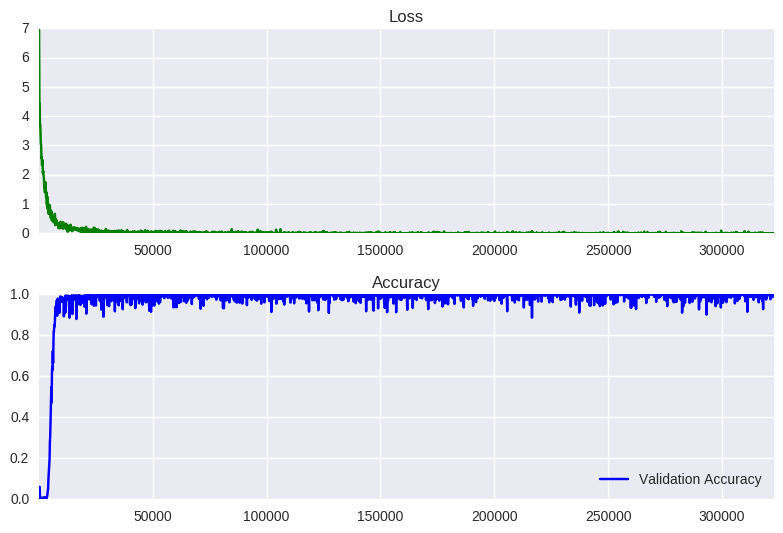

Best Validation loss at 4.654341283106363e-06 last iteration 322048
Validation accuracy at (0.99936240754909467, 5.0602092231015869e-05)


In [14]:
n_epochs = 377
epoch = 0
done_training = False
# The accuracy measured against the validation set
valid_accuracy = 0.0
best_valid_loss = np.inf
last_iteration = 0
improvement_threshold = 0.995

# Measurements use for graphing loss and accuracy
batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []

save_dir =  'model1/'

saver = tf.train.Saver(tf.global_variables())
init = tf.global_variables_initializer()

with tf.Session() as session:
    session.run(init)
    batch_count = int(math.ceil(len(X_train)/batch_size))

    while (epoch < n_epochs) and (not done_training):
        epoch = epoch + 1
        
        # Progress bar
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch, n_epochs), unit='batches')
        
        # The training cycle
        for batch_i in batches_pbar:
            iteration = (epoch - 1) * batch_count + batch_i
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            X_batch = X_train[batch_start:batch_start + batch_size]
            y_batch = y_train[batch_start:batch_start + batch_size]

            # Run optimizer and get loss
            _, l = session.run([optimizer, loss],feed_dict={X: X_batch, y: y_batch, keep_prob:0.5, is_training:True})

            # Log every 50 batches
            if not iteration % batch_size:
                # Calculate Training and Validation accuracy
                #training_accuracy = evaluate(X_train, y_train)
                valid_accuracy, valid_loss = evaluate(X_valid, y_valid)

                # Log batches
                previous_batch = batches[-1] if batches else 0
                batches.append(batch_size + previous_batch)
                loss_batch.append(l)
                #train_acc_batch.append(training_accuracy)
                valid_acc_batch.append(valid_accuracy)
            
            if not iteration % 512:
                if valid_loss < best_valid_loss*improvement_threshold:
                    best_valid_loss = valid_loss
                    last_iteration = iteration
                    checkpoint_path = os.path.join(save_dir, 'model.ckpt')
                    saver.save(session, checkpoint_path, global_step=iteration)
                
            if last_iteration - iteration > 987:
                done_training = True
                break
        

        # Check accuracy against Validation data
        validation_accuracy = evaluate(X_valid, y_valid)
        print('Validation accuracy at {}'.format(validation_accuracy))
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            last_iteration = iteration
            checkpoint_path = os.path.join(save_dir, 'session.ckpt')
            saver.save(session, checkpoint_path, global_step=iteration)
        
loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_batch, 'g')
loss_plot.set_xlim([batches[0], batches[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
#acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, valid_acc_batch, 'b', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()

print('Best Validation loss at {} last iteration {}'.format(best_valid_loss, last_iteration))
print('Validation accuracy at {}'.format(validation_accuracy))

In [15]:
save_dir = 'model1/'
with tf.Session() as session:
        saver = tf.train.Saver(tf.global_variables())
        ckpt = tf.train.latest_checkpoint(save_dir)
        saver.restore(session, ckpt)
        test_acc, test_loss = evaluate(X_test, y_test)
print("Test accuracy for augmented and balanced data with bottle-neck: {}".format(test_acc))


Test accuracy for augmented and balanced data with bottle-neck: 0.9521773552384909


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [16]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
from scipy import ndimage
import scipy as sp

In [17]:
x_images = []
y_images = []
dir_path = "/home/shreyas/Documents/sdcND/data/test_images/"
for image in os.listdir(dir_path):
        x_images.append(ndimage.imread(dir_path + image))
        y_images.append(int(image.split('.')[0]))
        
x_images = np.array(x_images)
y_images = np.array(y_images)
x_images /= 255

print(x_images[2].shape)

(601, 600, 3)


In [18]:
#resize images to match the model input
x_images = np.array([sp.misc.imresize(img, [32,32]) for img in x_images])

print(x_images[0].shape)

(32, 32, 3)


In [19]:
plot_img(x_images[:5],y_images[:5])

NameError: name 'plot_img' is not defined

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
save_dir = 'model1s/'

top_k = tf.nn.top_k(logits, k=5, sorted=True)
    
with tf.Session() as session:
        saver = tf.train.Saver(tf.global_variables())
        ckpt = tf.train.latest_checkpoint(save_dir)
        saver.restore(session, ckpt)
        test_acc, top_5= session.run([accuracy,top_k], feed_dict={X: x_images, y: y_images, keep_prob:1.0, is_training:False})
print("Test accuracy for original and imbalanced data with bottle-neck: {}".format(test_acc))
#print(top_5)

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
import pandas as pd
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(np.concatenate((y_train, y_test), axis=0))
def one_hot_encoding(data, lb):
    encoded = np.array(lb.transform(data))
    encoded_cls = lb.inverse_transform(encoded)
    
    return encoded, encoded_cls
y_images, y_cls = one_hot_encoding(y_images, lb)

In [ ]:
f, axarr = plt.subplots(2, 5, figsize=(12, 4))
f.suptitle('Top 5 - Prediction Certainty', fontsize=12, y=1.08)

for i, ax in enumerate(axarr[0]):
    ax.imshow(x_images[i])
    ax.set_title('%s - %s' % (y_cls[i], signnames[y_cls[i]]), fontsize=8)
    ax.axis('off')

for i, ax in enumerate(axarr[1]):
    data = pd.DataFrame([top_5.values[i]])
    ax.set_ylim([0, 1.0])
    sns.barplot(data=data, ax=ax, color='lightblue', ci=None)
    
    _ = ax.set_xticklabels(['%s - %s'% (signnames[j], j) for j in top_5.indices[i]], rotation=90)
    
    [tick.set_color("red") for j, tick in enumerate(ax.get_xticklabels()) if top_5.indices[i][j] == y_cls[i]]

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.